In [1]:
############################################
### Import required modules### 
############################################

# Basic operations and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###################################################
# needed for drop down menus
from IPython.display import display
import ipywidgets as widgets

###################################################
# Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

###################################################
# Plotting earthquake uccurrences (distiguishing < 5 magnitude & => 5 magnitude) over New Zealand map
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from matplotlib.lines import Line2D

In [25]:
# Read earthquake data file
df_major_quake_cty = pd.read_csv('df_major_quake_cty.csv', low_memory=False) 

# Note: Added low_memory=False to process the file in chunks, which helps pandas determine the appropriate 
# data type for each column.

# Read cities data file for (online resource: https://simplemaps.com/data/nz-cities)
# Used in plot showing the Distribution of earthquake events superimposed on New Zealand map in cell 17
df_cities_cln = pd.read_csv('df_cities_cln.csv', low_memory=False) 
############################################
# First 5 rows of the dataframes
display(df_major_quake_cty.head().T)

print('-'*55)

display(df_cities_cln.head().T)

,0,1,2,3,4
Time,2024-06-16 21:17:02.885000+00:00,2024-06-16 19:43:44.300000+00:00,2024-06-16 15:30:04.397000+00:00,2024-06-16 14:08:12.741000+00:00,2024-06-16 13:48:21.374000+00:00
UnixTime,1718572622,1718567024,1718551804,1718546892,1718545701
Longitude,145.008865,-176.719513,-179.818893,-179.120789,-177.3965
Latitude,19.403189,-30.431572,-37.200104,-21.52416,-20.054701
Magnitude,5.0,3.7,3.6,4.8,4.7
Magnitude Type,Mw(mB),Mw(mB),MLv,mB,mB
Depth,100.0,253.26,33.0,638.67,512.18
NZ_MMI,Moderate,Weak,Weak,Light,Light
Adjusted Distance,70.402322,37.846756,9.796214,85.439839,74.129297
Nearest City,Kaitaia,Waitangi,Waitangi,Waitangi,Waitangi


-------------------------------------------------------


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
city,Auckland,Christchurch,Manukau City,Wellington,Northcote
lat,-36.8406,-43.531,-37.0,-41.2889,-36.8019
lng,174.74,172.6365,174.885,174.7772,174.7494
country,New Zealand,New Zealand,New Zealand,New Zealand,New Zealand
population,1346091,383200,375600,216200,205605


In [3]:
# Checking the data type of the 'Time' column
print(df_major_quake_cty['Time'].dtype)

object


In [4]:
# There seems to be mixed formatting, use 'mixed' option:
df_major_quake_cty['Time'] = pd.to_datetime(df_major_quake_cty['Time'], format='mixed')

# Print a sample to verify the conversion
print(df_major_quake_cty['Time'].head())

0   2024-06-16 21:17:02.885000+00:00
1   2024-06-16 19:43:44.300000+00:00
2   2024-06-16 15:30:04.397000+00:00
3   2024-06-16 14:08:12.741000+00:00
4   2024-06-16 13:48:21.374000+00:00
Name: Time, dtype: datetime64[ns, UTC]


In [5]:
############################################
# Filter for  major events (M >= 6.0)
# Calculate average magnitude of major events
############################################

# Step 1: Filter earthquake data for major events with magnitude >= 6.0
major_events = df_major_quake_cty[df_major_quake_cty['Magnitude'] >= 6.0]

# Step 2: Perform analysis on the filtered major events
num_major_events = len(major_events)
avg_magnitude = major_events['Magnitude'].mean()

# Step 3: Display or store results
print("Filtered Major Earthquake Events with Magnitude >= 6.0:")
print("Number of Major Events: {}".format(num_major_events))
print("Average Magnitude of Major Events: {}".format(avg_magnitude))

Filtered Major Earthquake Events with Magnitude >= 6.0:
Number of Major Events: 520
Average Magnitude of Major Events: 6.379423076923076


In [6]:
############################################
# Isolation Forest prediction
############################################

df_quake_pred = df_major_quake_cty.copy()  # Copy to preserve original

# Select relevant features for Isolation Forest
X = df_major_quake_cty[['Longitude', 'Latitude', 'Magnitude', 'Depth']]

# Train-test split (optional, if you haven't already split your data)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train Isolation Forest model on the training set
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X_train)

# Predict outliers (anomalies) for the entire dataset (df_quake_pred)
predictions = clf.predict(df_quake_pred[['Longitude', 'Latitude', 'Magnitude', 'Depth']])

# Assign predictions to df_quake_pred
df_quake_pred['Anomaly'] = predictions

# Display df_quake_pred to verify the update
print("Updated df_quake_pred with Anomaly:")
display(df_quake_pred.head().T)

# Filter predicted major events (anomalies)
predicted_major_events = df_quake_pred[df_quake_pred['Anomaly'] == -1]
predicted_major_events.head().T

# Calculate metrics for predicted major events
num_major_events = len(predicted_major_events)
avg_magnitude = predicted_major_events['Magnitude'].abs().mean()  # Use absolute value for average magnitude

############################################
print('The average magnitude over the studied timeframe is:', avg_magnitude)

Updated df_quake_pred with Anomaly:


,0,1,2,3,4
Time,2024-06-16 21:17:02.885000+00:00,2024-06-16 19:43:44.300000+00:00,2024-06-16 15:30:04.397000+00:00,2024-06-16 14:08:12.741000+00:00,2024-06-16 13:48:21.374000+00:00
UnixTime,1718572622,1718567024,1718551804,1718546892,1718545701
Longitude,145.008865,-176.719513,-179.818893,-179.120789,-177.3965
Latitude,19.403189,-30.431572,-37.200104,-21.52416,-20.054701
Magnitude,5.0,3.7,3.6,4.8,4.7
Magnitude Type,Mw(mB),Mw(mB),MLv,mB,mB
Depth,100.0,253.26,33.0,638.67,512.18
NZ_MMI,Moderate,Weak,Weak,Light,Light
Adjusted Distance,70.402322,37.846756,9.796214,85.439839,74.129297
Nearest City,Kaitaia,Waitangi,Waitangi,Waitangi,Waitangi


The average magnitude over the studied timeframe is: 5.06668372569089


In [7]:
# Calculate metrics for predicted major events
num_major_events = len(predicted_major_events)
avg_magnitude = predicted_major_events['Magnitude'].abs().mean()  # absolute value for average magnitude

print('The average magnitude over the studied timeframe is:', avg_magnitude)

The average magnitude over the studied timeframe is: 5.06668372569089


In [8]:
############################################
# Identifying the top 10 most earth quake prone cities in New Zealand
# using Isolation Forest Evaluation
############################################

# Dictionary to store city vulnerability metrics
city_vulnerability = {}

# Iterate over unique city names
for city_name in df_quake_pred['Nearest City'].unique():
    city_data = df_quake_pred[df_quake_pred['Nearest City'] == city_name]
    
    # Count anomalies (major events)
    count_major_events = city_data[city_data['Anomaly'] == -1].shape[0]
    
    # Calculate metrics for the city
    city_vulnerability[city_name] = {'Population Density': city_data['Population'].iloc[0], 'Count of Major Events': count_major_events,
        'Average Magnitude': city_data[city_data['Anomaly'] == -1]['Magnitude'].abs().mean()}  # Use absolute value for average magnitude

# Sort cities by count of major events (descending) and limit to top 10
top_10_cities = sorted(city_vulnerability.items(), key=lambda x: x[1]['Count of Major Events'], reverse=True)[:10]

# Prepare lists to store top 10 cities vulnerability metrics
ranks = []
cities = []
pop_densities = []
major_events_counts = []
avg_magnitudes = []

# Collect vulnerability metrics for top 10 cities
for rank, (city_name, metrics) in enumerate(top_10_cities, start=1):
    ranks.append(rank)
    cities.append(city_name)
    pop_densities.append(metrics['Population Density'])
    major_events_counts.append(metrics['Count of Major Events'])
    avg_magnitudes.append(metrics['Average Magnitude'])

# Create DataFrame from collected lists
top_10_df = pd.DataFrame({
    'Rank': ranks,
    'City': cities,
    'Population Density': pop_densities,
    'Count of Major Events': major_events_counts,
    'Average Magnitude': avg_magnitudes})

############################################
# Display the DataFrame directly
top_10_df

,Rank,City,Population Density,Count of Major Events,Average Magnitude
0,1,Waitangi,2018,1909,4.851545
1,2,Kaitaia,5868,1387,5.465681
2,3,Kerikeri,6960,308,4.674351
3,4,Whitianga,5130,235,4.107234
4,5,Wakefield,2448,25,9.000000
5,6,Whakatane,15795,13,8.061538
6,7,Te Anau,2250,9,5.355556
7,8,Rotorua,54204,7,9.000000
8,9,Te Puke,8230,4,7.175000
9,10,Mount Maunganui,6510,3,7.833333


# Break down of each used metric:

- **Count of Major Events:** The number of times an anomaly (major event) was detected for each city.
- **Average Magnitude:** The average magnitude of these major events for each city.
- **Population Density:** The population density of each city.

In [81]:
############################################
# Adjusting ranking basde on prediction of when and where the next major event will take place
############################################

# Define magnitude threshold (assuming filtering already done)
magnitude_threshold = 5.0

# Extract major events (Anomaly == -1)
major_quakes = df_quake_pred[df_quake_pred['Anomaly'] == -1][['Time', 'Nearest City', 'Magnitude']]

# Sort by time
major_quakes = major_quakes.sort_values(by='Time')

# Calculate intervals between successive major quakes for each city
major_quakes['Previous Time'] = major_quakes.groupby('Nearest City')['Time'].shift(1)
major_quakes['Interval (Days)'] = (major_quakes['Time'] - major_quakes['Previous Time']).dt.days

# Calculate average interval for each city
average_intervals = major_quakes.groupby('Nearest City')['Interval (Days)'].mean().reset_index()
average_intervals.rename(columns={'Interval (Days)': 'Average Interval (Days)'}, inplace=True)

# Get the last major quake date for each city
last_quake_dates = major_quakes.groupby('Nearest City')['Time'].max().reset_index()

# Merge average intervals with the last quake dates
last_quake_dates = last_quake_dates.merge(average_intervals, on='Nearest City')

# Predict the next earthquake date for each city
last_quake_dates['Next Major Quake Date'] = last_quake_dates['Time'] + pd.to_timedelta(last_quake_dates['Average Interval (Days)'], unit='days')

# Adjust dates that are still in the past by adding another average interval
today = pd.Timestamp.now(tz=df_quake_pred['Time'].dt.tz)
last_quake_dates['Next Major Quake Date'] = last_quake_dates.apply(
    lambda row: row['Next Major Quake Date'] if row['Next Major Quake Date'] > today else row['Next Major Quake Date'] + pd.to_timedelta(row['Average Interval (Days)'], unit='days') * ((today - row['Next Major Quake Date']).days // row['Average Interval (Days)'] + 1),
    axis=1)

# Calculate years from today
last_quake_dates['Years Until Next Quake'] = (last_quake_dates['Next Major Quake Date'] - today).dt.days / 365.25

# Filter for top 10 cities
top_10_cities = top_10_df['City'].tolist()
top_10_predictions = last_quake_dates[last_quake_dates['Nearest City'].isin(top_10_cities)]

# Display the predictions
top_10_predictions = top_10_predictions[['Nearest City', 'Next Major Quake Date', 'Years Until Next Quake']]
display(top_10_predictions)

,Nearest City,Next Major Quake Date,Years Until Next Quake
1,Kaitaia,2024-06-22 14:06:55.092792216+00:00,0.005476
2,Kerikeri,2024-07-04 06:31:31.657061890+00:00,0.035592
3,Mount Maunganui,2026-08-22 03:35:27.253000+00:00,2.168378
5,Rotorua,2024-07-23 09:02:27.759000258+00:00,0.090349
8,Te Anau,2024-08-13 14:08:24+00:00,0.147844
9,Te Puke,2026-05-07 17:47:26.309000014+00:00,1.878166
11,Waitangi,2024-06-20 12:04:26.325905661+00:00,0.000000
12,Wakefield,2024-07-12 08:20:29.024999869+00:00,0.060233
14,Whakatane,2024-08-24 13:25:50.841000013+00:00,0.177960
15,Whitianga,2024-07-04 06:44:45.202384626+00:00,0.035592


In [82]:
############################################
# Sort years to major quake output (descending order) for top10 most earthquake prone cities in NZ
############################################

# 1. Sort by Years Until Next Quake in descending order
top_10_predictions = top_10_predictions.sort_values(by='Years Until Next Quake', ascending = False)

############################################
# Display the predictions
top_10_predictions = top_10_predictions[['Nearest City', 'Next Major Quake Date', 'Years Until Next Quake']]
display(top_10_predictions)

,Nearest City,Next Major Quake Date,Years Until Next Quake
3,Mount Maunganui,2026-08-22 03:35:27.253000+00:00,2.168378
9,Te Puke,2026-05-07 17:47:26.309000014+00:00,1.878166
14,Whakatane,2024-08-24 13:25:50.841000013+00:00,0.177960
8,Te Anau,2024-08-13 14:08:24+00:00,0.147844
5,Rotorua,2024-07-23 09:02:27.759000258+00:00,0.090349
12,Wakefield,2024-07-12 08:20:29.024999869+00:00,0.060233
2,Kerikeri,2024-07-04 06:31:31.657061890+00:00,0.035592
15,Whitianga,2024-07-04 06:44:45.202384626+00:00,0.035592
1,Kaitaia,2024-06-22 14:06:55.092792216+00:00,0.005476
11,Waitangi,2024-06-20 12:04:26.325905661+00:00,0.000000


# Explanation - Why Mt Manganui and Rotorua rank highest when predicting the time to next major earthquake but very low based on the frequency of major anomalies (=Isolation Forest) #

1. **Isolation Forest Output (Count of Major Events):** This ranking is based on the count of major anomalies detected in the dataset. Cities with a higher
   number of detected anomalies are considered more prone to earthquakes based on historical data.
       Note: Isolation Forest Ranking evaluation ranks cities based on the frequency of major anomalies detected.

2. **Years Until Next Major Earthquake:** This prediction is based on the average interval between major earthquakes for each city and the date of the last
   detected major earthquake. A city might have fewer major events historically but a shorter average interval between those events, leading to a prediction
   of a sooner next major earthquake.
       Note: "Years Until Next Major Earthquake" evaluation predicts when the next major earthquake is likely to occur based on the historical intervals
       between major events for each city.

In [11]:
df_quake_cty = pd.read_csv('df_quake_cty_24.csv', low_memory=False) 

In [69]:
############################################
# Geographical Distribution
# Calculating the proportion of towns and major earthquakes on each island.
############################################

# Classify towns as North or South Island based on their coordinates
def classify_island(row):
    if row['Latitude'] < -40:  # Rough latitude to separate North and South Island
        return 'South Island'
    else:
        return 'North Island'

df_quake_pred['Island'] = df_quake_pred.apply(classify_island, axis=1)

# Count the number of towns and major earthquakes on each island
town_counts = df_quake_pred[['Nearest City', 'Island']].drop_duplicates()['Island'].value_counts()
major_quake_counts = df_quake_pred[df_quake_pred['Anomaly'] == -1]['Island'].value_counts()

# Combine into a DataFrame for easier comparison
island_comparison = pd.DataFrame({
    'Town Count': town_counts,
    'Major Earthquake Count': major_quake_counts
}).fillna(0)

# Calculate the proportions
island_comparison['Town Proportion'] = island_comparison['Town Count'] / island_comparison['Town Count'].sum()
island_comparison['Major Earthquake Proportion'] = island_comparison['Major Earthquake Count'] / island_comparison['Major Earthquake Count'].sum()

display(island_comparison)


,Town Count,Major Earthquake Count,Town Proportion,Major Earthquake Proportion
Island,,,,
North Island,26,3763,0.433333,0.962897
South Island,34,145,0.566667,0.037103


In [70]:
############################################
# Analyzing the average population density of towns on each island.
############################################

# Calculate average population density for each island
island_population_density = df_quake_pred[['Nearest City', 'Population', 'Island']].drop_duplicates().groupby('Island')['Population'].mean()

display(island_population_density)

Island
North Island    17867.346154
South Island    31816.058824
Name: Population, dtype: float64

In [71]:
############################################
# Geographical Distribution
  # 1. Calculating the proportion of towns and major earthquakes on each island.
  # 2. Analyzing the average population density of towns on each island.
############################################

# 1. Proportion of towns and major earthquakes on each island

# Allocating the towns to their respective island - North or South Island - based on their coordinates
def classify_island(row):
    if row['Latitude'] < -40:  # Rough latitude to separate North and South Island
        return 'South Island'
    else:
        return 'North Island'

df_quake_pred['Island'] = df_quake_pred.apply(classify_island, axis=1)

# Count the number of towns and major earthquakes on each island
town_counts = df_quake_pred[['Nearest City', 'Island']].drop_duplicates()['Island'].value_counts()
major_quake_counts = df_quake_pred[df_quake_pred['Anomaly'] == -1]['Island'].value_counts()

############################################
# 2. Average population density of towns on each island.

# Calculate average population density for each island
island_population_density = df_quake_pred[['Nearest City', 'Population', 'Island']].drop_duplicates().groupby('Island')['Population'].mean()

############################################
# Combine into a DataFrame for easier comparison
island_comparison = pd.DataFrame({'Town Count': town_counts, 'Major Earthquake Count': major_quake_counts,
    'Average Population Density': island_population_density}).fillna(0)

# Calculate the proportions
island_comparison['Town Proportion'] = island_comparison['Town Count'] / island_comparison['Town Count'].sum()
island_comparison['Major Earthquake Proportion'] = island_comparison['Major Earthquake Count'] / island_comparison['Major Earthquake Count'].sum()

############################################
# Display dataframe
display(island_comparison)


,Town Count,Major Earthquake Count,Average Population Density,Town Proportion,Major Earthquake Proportion
Island,,,,,
North Island,26,3763,17867.346154,0.433333,0.962897
South Island,34,145,31816.058824,0.566667,0.037103


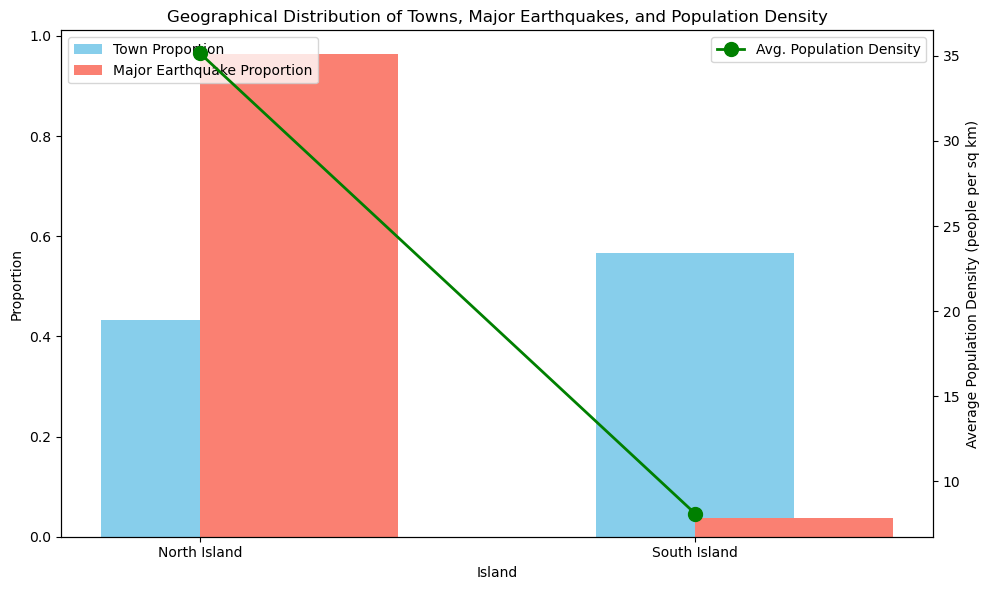

In [72]:
############################################
# Geographical Distribution
  # 1. Calculating the proportion of towns and major earthquakes on each island.
  # 2. Analyzing the average population density of towns on each island.
############################################

# Total populations of North and South Islands
total_population_north = 3997300 # source Wikipedia
total_population_south = 1225000 # source Wikipedia

# Land area (in square kilometers) for each island (assumed for the example)
# Replace with actual values if available
land_area_north = 113729  # source Wikipedia (unit in sqr km)
land_area_south = 151215  # source Wikipedia (unit in sqr km)

# Calculate population densities
population_density_north = total_population_north / land_area_north
population_density_south = total_population_south / land_area_south

island_data = {'Island': ['North Island', 'South Island'],
    'Town Proportion': [0.433333, 0.566667],  # calculated above in cell 14
    'Major Earthquake Proportion': [0.962897, 0.037103],  # calculated above in cell 14
    'Average Population Density': [population_density_north, population_density_south]}

island_comparison = pd.DataFrame(island_data).set_index('Island')

# Data extraction from island_comparison data frame
island_names = island_comparison.index
town_proportions = island_comparison['Town Proportion']
quake_proportions = island_comparison['Major Earthquake Proportion']
avg_pop_densities = island_comparison['Average Population Density']

############################################
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot proportions of towns and major earthquakes
bar_width = 0.4
ax1.bar(island_names, town_proportions, width=bar_width, label='Town Proportion', color='skyblue', align='center')
ax1.bar(island_names, quake_proportions, width=bar_width, label='Major Earthquake Proportion', color='salmon', align='edge')

# Create a secondary y-axis for average population density
ax2 = ax1.twinx()
ax2.plot(island_names, avg_pop_densities, marker='o', color='green', linestyle='-', linewidth=2, markersize=10, label='Avg. Population Density')

# Set labels and title
ax1.set_xlabel('Island')
ax1.set_ylabel('Proportion')
ax2.set_ylabel('Average Population Density (people per sq km)')
ax1.set_title('Geographical Distribution of Towns, Major Earthquakes, and Population Density')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot as an image file
plt.savefig('GeogrDistribution_Towns_Major_Quakes_Population.png', dpi=300)

############################################
# Layout and display
plt.tight_layout()
plt.show()

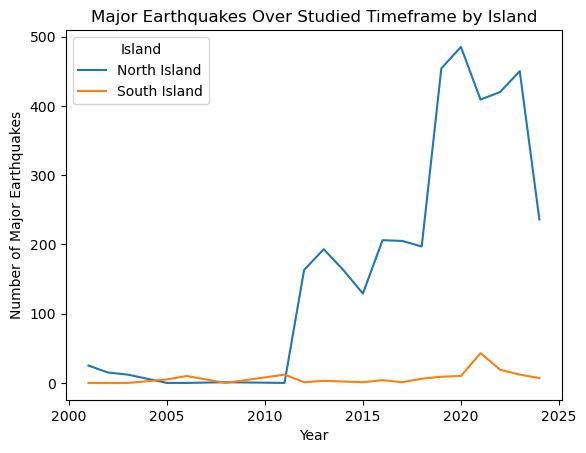

In [73]:
############################################
# Historical Data
  # Comparing the number of earthquakes over studied timeframe for both islands.
############################################

# Count major earthquakes over time for each island
df_quake_pred['Year'] = df_quake_pred['Time'].dt.year
quake_counts_by_year = df_quake_pred[df_quake_pred['Anomaly'] == -1].groupby(['Year', 'Island']).size().unstack(fill_value=0)

# Plot the trends over time
quake_counts_by_year.plot(kind='line')
plt.title('Major Earthquakes Over Studied Timeframe by Island')
plt.xlabel('Year')
plt.ylabel('Number of Major Earthquakes')

# Save the plot as an image file
plt.savefig('MajorQuakes_NorthVsSouth.png', dpi=300)
############################################
# Graph output
plt.show()

/var/folders/jw/r1sgx_px7r13hq355w049qcw0000gn/T/ipykernel_57409/1164935259.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/jw/r1sgx_px7r13hq355w049qcw0000gn/T/ipykernel_57409/1164935259.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


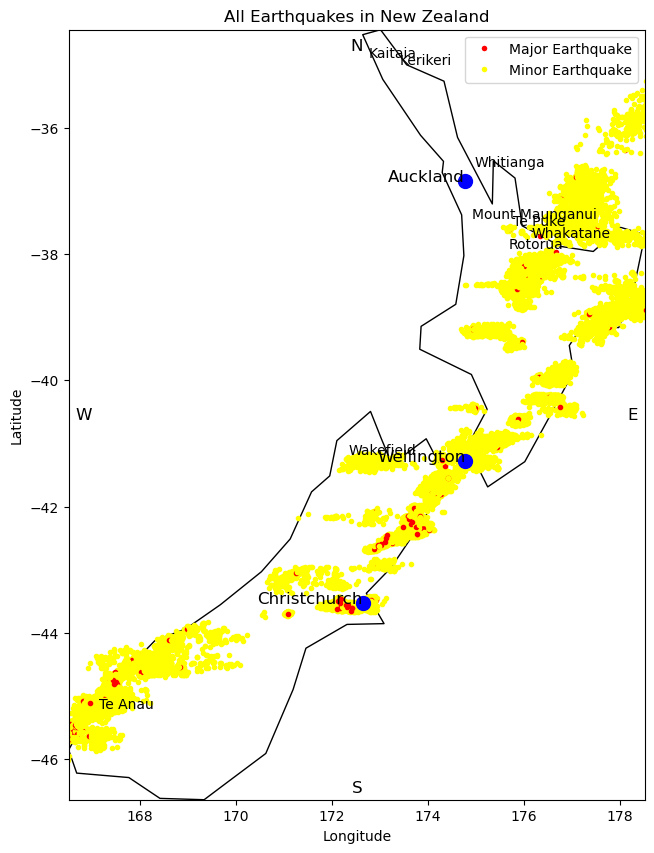

In [83]:
############################################
# Plotting earthquake uccurrences (distiguishing < 5 magnitude & => 5 magnitude) over New Zealand map
############################################

# Read the shapefile for the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for New Zealand
new_zealand = world[world['name'] == 'New Zealand']

# Get the longitude and latitude extents of New Zealand
minx, miny, maxx, maxy = new_zealand.total_bounds

# Calculate the midpoint of the latitude and longitude extents
mid_lon = (minx + maxx) / 2
mid_lat = (miny + maxy) / 2

# Plot New Zealand with a fixed aspect ratio and custom extent
fig, ax = plt.subplots(figsize=(10, 10))
new_zealand.plot(ax=ax, color='white', edgecolor='black')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot all earthquake events with different colors based on magnitude
cmap = plt.cm.get_cmap('viridis')  
norm = plt.Normalize(df_quake_pred['Magnitude'].min(), df_quake_pred['Magnitude'].max())  # Normalize the magnitudes
for idx, quake in df_quake_pred.iterrows():
    if quake['Magnitude'] >= 5.0:
        color = 'red'  # Major quakes in red
    else:
        color = 'green'  # Minor quakes in green
    ax.plot(quake['Longitude'], quake['Latitude'], marker='o', color=color, markersize=3)

# Create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Major Earthquake'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=5, label='Minor Earthquake')]
ax.legend(handles=legend_elements, loc='upper right')

# Listing specific towns to plot (top 10 earthquake prone towns)
towns_to_plot = ['Waitangi', 'Kaitaia', 'Kerikeri', 'Whitianga', 'Wakefield', 'Whakatane', 'Te Anau', 'Rotorua', 'Te Puke', 'Mount Maunganui']

# Filtering the DataFrame for the specified towns
filtered_towns = df_cities_cln[df_cities_cln['city'].isin(towns_to_plot)]

# Annotate towns on the plot
for idx, row in filtered_towns.iterrows():
    ax.annotate(row['city'], (row['lng'], row['lat']), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight major cities
major_cities = {'Auckland': {'lat': -36.8485, 'lng': 174.7633},'Wellington': {'lat': -41.2865, 'lng': 174.7762},
    'Christchurch': {'lat': -43.5321, 'lng': 172.6362}}

for city, coords in major_cities.items():
    plt.plot(coords['lng'], coords['lat'], marker='o', color='blue', markersize=10)
    plt.text(coords['lng'], coords['lat'], city, fontsize=12, ha='right')

# Add cardinal directions
ax.annotate('N', xy=(mid_lon, maxy), xytext=(0, -15), textcoords='offset points', ha='center', fontsize=12)
ax.annotate('S', xy=(mid_lon, miny), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=12)
ax.annotate('E', xy=(maxx, mid_lat), xytext=(-12.5, xa0), textcoords='offset points', va='center', fontsize=12)
ax.annotate('W', xy=(minx, mid_lat), xytext=(5, 0), textcoords='offset points', va='center', fontsize=12)

# Save the plot as an image file
plt.savefig('All_Quakes_Scatter.png', dpi=300)

# Output graph
plt.title('All Earthquakes in New Zealand')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()